In [1]:
import pandas as pd
import numpy as np
from nba_api.stats.endpoints import *
import json
from tqdm import tqdm
import os
import matplotlib.pyplot as plt

In [2]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

### Get PPP and total possessions for all teams

In [3]:
def get_df_from_json(team_stats_json):
    """
    Get DataFrame format of json data
    
    Parameters:
    - team_stats_json: json of data
    
    Returns:
    - team_stats_df: json data as a Pandas DataFrame
    """
    # Load the JSON data into a DataFrame
    team_stats_df = pd.DataFrame(
        json.loads(team_stats_json)['resultSets'][0]['rowSet'], 
        columns = json.loads(team_stats_json)['resultSets'][0]['headers']
    )
    
    return team_stats_df


def get_shot_clock_splits(shot_clock_lst, season = '2024-25'):
    """
    Get shot clock split data from the NBA API
    
    Parameters:
    - shot_clock_lst: List of shot clock ranges
    - season: NBA season (default '2024-25')
    
    Returns:
    - shot_clock_dfs: Dictionary of DataFrames for each shot clock range with the range as the key
    """
    shot_clock_dfs = {}
    
    # Loop through the different shot clock timeframes
    for timeframe in shot_clock_lst:
        
        # Pull the JSON data for the year and shot clock timeframe
        per_poss_stats = leaguedashteamstats.LeagueDashTeamStats(
            season = season, 
            shot_clock_range_nullable = timeframe
        ).get_json()
        per_poss_df = get_df_from_json(per_poss_stats)
        
        # Pull the JSON Advanced data for the year and shot clock timeframe
        adv_stats = leaguedashteamstats.LeagueDashTeamStats(
            season = season, 
            shot_clock_range_nullable = timeframe, 
            measure_type_detailed_defense = 'Advanced'
        ).get_json()
        adv_df = get_df_from_json(adv_stats)
        
        # Merge the two DataFrames together on 'TEAM_ID' and filter to the columns we care about
        team_stats_df = per_poss_df.merge(adv_df, on=['TEAM_ID', 'TEAM_NAME'], how='inner')
        team_stats_df = team_stats_df[['TEAM_ID', 'TEAM_NAME', 'PTS', 'POSS']]
        
        shot_clock_dfs[timeframe] = team_stats_df
        
    return shot_clock_dfs

In [4]:
# Load the shot clock data at a per 100 possesssions split into the 
shot_clock_lst = ['24-22', '22-18 Very Early', '18-15 Early', '15-7 Average', '7-4 Late', '4-0 Very Late']
shot_clock_dfs = get_shot_clock_splits(shot_clock_lst)

In [5]:
shot_clock_dfs['22-18 Very Early']

,TEAM_ID,TEAM_NAME,PTS,POSS
0,1610612737,Atlanta Hawks,1204,1478
1,1610612738,Boston Celtics,845,977
2,1610612751,Brooklyn Nets,866,1116
3,1610612766,Charlotte Hornets,825,1050
4,1610612741,Chicago Bulls,1306,1593
5,1610612739,Cleveland Cavaliers,1051,1168
6,1610612742,Dallas Mavericks,1008,1191
7,1610612743,Denver Nuggets,1283,1483
8,1610612765,Detroit Pistons,1191,1369
9,1610612744,Golden State Warriors,1020,1251


In [6]:
shot_clock_dfs['22-18 Very Early'].info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 30 entries, 0 to 29
Data columns (total 4 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   TEAM_ID    30 non-null     int64 
 1   TEAM_NAME  30 non-null     object
 2   PTS        30 non-null     int64 
 3   POSS       30 non-null     int64 
dtypes: int64(3), object(1)
memory usage: 1.2+ KB


### Get PPP as a weighted average for the whole remaining shot clock

In [7]:
def aggregate_shot_clock_data(shot_clock_dfs, shot_clock_lst):
    """
    Aggregates shot clock data across a selcted list of timeframes to calculate a weighted average of PPP per team

    Parameters:
    - shot_clock_dfs: Dictionary of DataFrames, where keys represent shot clock ranges
    - shot_clock_lst: List of shot clock ranges to aggregate

    Returns:
    - final_df: A DataFrame with TEAM_ID, TEAM_NAME, weighted PTS per possession, and total POSS.
    """
    # Initialize variables
    aggregated_data = []
    shot_clock_remaining = shot_clock_lst[0].split(' ')[0]
    
    # Loop through each shot clock range in the list
    for timeframe in shot_clock_lst:
        aggregated_data.append(shot_clock_dfs[timeframe])

    # Combine all dataframes
    merged_df = pd.concat(aggregated_data)

    # Aggregate by TEAM_ID and TEAM_NAME
    final_df = merged_df.groupby(['TEAM_ID', 'TEAM_NAME'], as_index=False).agg(
        Total_POSS=('POSS', 'sum'),
        Total_PTS=('PTS', 'sum')
    )

    # Calculate final weighted PTS per possession
    final_df['PPP'] = final_df['Total_PTS'] / final_df['Total_POSS']
    final_df['SC_REMAINING'] = shot_clock_remaining

    return final_df

In [8]:
final_shot_clock_dfs = {}
shot_clock_lst = ['24-22', '22-18 Very Early', '18-15 Early', '15-7 Average', '7-4 Late', '4-0 Very Late']

while len(shot_clock_lst) > 0:
    agg_df = aggregate_shot_clock_data(shot_clock_dfs, shot_clock_lst)
    sc = shot_clock_lst.pop(0)
    final_shot_clock_dfs[sc] = agg_df

In [9]:
for timeframe in final_shot_clock_dfs:
    print(final_shot_clock_dfs[timeframe].head())

      TEAM_ID             TEAM_NAME  Total_POSS  Total_PTS       PPP  \
0  1610612737         Atlanta Hawks       11197       7366  0.657855   
1  1610612738        Boston Celtics       10340       7150  0.691489   
2  1610612739   Cleveland Cavaliers       10815       7753  0.716875   
3  1610612740  New Orleans Pelicans       10892       6978  0.640654   
4  1610612741         Chicago Bulls       11010       7335  0.666213   

  SC_REMAINING  
0        24-22  
1        24-22  
2        24-22  
3        24-22  
4        24-22  
      TEAM_ID             TEAM_NAME  Total_POSS  Total_PTS       PPP  \
0  1610612737         Atlanta Hawks        8191       5972  0.729093   
1  1610612738        Boston Celtics        7510       6016  0.801065   
2  1610612739   Cleveland Cavaliers        7992       6471  0.809685   
3  1610612740  New Orleans Pelicans        7913       5636  0.712246   
4  1610612741         Chicago Bulls        8042       6165  0.766600   

  SC_REMAINING  
0        22-18 

### Evaluate Scaling from ORating
Offensive rating from the shot clock splits in the API is abnormally low for all splits. When aggregated it makes sense to scale those numbers up equally to achieve a more representative value for the PPP. Here the factor to scale up by is calculated and evaluated for each team.

In [16]:
# Pull the overall aggregated data based on the shot clock
full_sc = final_shot_clock_dfs['24-22']
full_sc

,TEAM_ID,TEAM_NAME,Total_POSS,Total_PTS,PPP,SC_REMAINING
0,1610612737,Atlanta Hawks,11197,7366,0.657855,24-22
1,1610612738,Boston Celtics,10340,7150,0.691489,24-22
2,1610612739,Cleveland Cavaliers,10815,7753,0.716875,24-22
3,1610612740,New Orleans Pelicans,10892,6978,0.640654,24-22
4,1610612741,Chicago Bulls,11010,7335,0.666213,24-22
5,1610612742,Dallas Mavericks,10961,7328,0.668552,24-22
6,1610612743,Denver Nuggets,10694,7551,0.706097,24-22
7,1610612744,Golden State Warriors,10856,7011,0.645818,24-22
8,1610612745,Houston Rockets,11149,7096,0.636470,24-22
9,1610612746,LA Clippers,10460,6868,0.656597,24-22


In [11]:
# Pull the overall offensive rating for each team without the shotclock filter
off_rating_stats = leaguedashteamstats.LeagueDashTeamStats(
                        season = '2024-25',
                        measure_type_detailed_defense = 'Advanced'
                    ).get_json()
orating_df = get_df_from_json(off_rating_stats)[['TEAM_ID', 'TEAM_NAME', 'OFF_RATING']]
orating_df['orating_PPP'] = orating_df['OFF_RATING'] / 100
orating_df

,TEAM_ID,TEAM_NAME,OFF_RATING,orating_PPP
0,1610612737,Atlanta Hawks,111.9,1.119
1,1610612738,Boston Celtics,119.2,1.192
2,1610612751,Brooklyn Nets,108.6,1.086
3,1610612766,Charlotte Hornets,106.7,1.067
4,1610612741,Chicago Bulls,112.0,1.120
5,1610612739,Cleveland Cavaliers,122.1,1.221
6,1610612742,Dallas Mavericks,114.1,1.141
7,1610612743,Denver Nuggets,119.4,1.194
8,1610612765,Detroit Pistons,113.7,1.137
9,1610612744,Golden State Warriors,113.4,1.134


In [17]:
# Merge the dataframes and calculate the factor needed for each team to reach their overall offensive rating from the shot clock aggregation
scaling_df = full_sc.merge(orating_df, on=['TEAM_ID', 'TEAM_NAME'], how='inner')
scaling_df['factor'] = scaling_df['orating_PPP'] / scaling_df['PPP']
scaling_df

,TEAM_ID,TEAM_NAME,Total_POSS,Total_PTS,PPP,SC_REMAINING,OFF_RATING,orating_PPP,factor
0,1610612737,Atlanta Hawks,11197,7366,0.657855,24-22,111.9,1.119,1.700983
1,1610612738,Boston Celtics,10340,7150,0.691489,24-22,119.2,1.192,1.723815
2,1610612739,Cleveland Cavaliers,10815,7753,0.716875,24-22,122.1,1.221,1.703226
3,1610612740,New Orleans Pelicans,10892,6978,0.640654,24-22,110.3,1.103,1.721679
4,1610612741,Chicago Bulls,11010,7335,0.666213,24-22,112.0,1.120,1.681145
5,1610612742,Dallas Mavericks,10961,7328,0.668552,24-22,114.1,1.141,1.706673
6,1610612743,Denver Nuggets,10694,7551,0.706097,24-22,119.4,1.194,1.690986
7,1610612744,Golden State Warriors,10856,7011,0.645818,24-22,113.4,1.134,1.755913
8,1610612745,Houston Rockets,11149,7096,0.636470,24-22,113.8,1.138,1.787988
9,1610612746,LA Clippers,10460,6868,0.656597,24-22,111.8,1.118,1.702720


In [18]:
# Calculate the average factor for all teams
factor_avg = scaling_df['factor'].mean()
print(f'Factor average from shot clock PPP to overall PPP is {factor_avg}')

Factor average from shot clock PPP to overall PPP is 1.7159412974222361


In [19]:
# Create a visual evaluation of the difference in factor from the average for each team
scaling_df['avg_factor_diff'] = (scaling_df['factor'] - factor_avg) * 100
scaling_df

,TEAM_ID,TEAM_NAME,Total_POSS,Total_PTS,PPP,SC_REMAINING,OFF_RATING,orating_PPP,factor,avg_factor_diff
0,1610612737,Atlanta Hawks,11197,7366,0.657855,24-22,111.9,1.119,1.700983,-1.495800
1,1610612738,Boston Celtics,10340,7150,0.691489,24-22,119.2,1.192,1.723815,0.787409
2,1610612739,Cleveland Cavaliers,10815,7753,0.716875,24-22,122.1,1.221,1.703226,-1.271480
3,1610612740,New Orleans Pelicans,10892,6978,0.640654,24-22,110.3,1.103,1.721679,0.573769
4,1610612741,Chicago Bulls,11010,7335,0.666213,24-22,112.0,1.120,1.681145,-3.479610
5,1610612742,Dallas Mavericks,10961,7328,0.668552,24-22,114.1,1.141,1.706673,-0.926813
6,1610612743,Denver Nuggets,10694,7551,0.706097,24-22,119.4,1.194,1.690986,-2.495520
7,1610612744,Golden State Warriors,10856,7011,0.645818,24-22,113.4,1.134,1.755913,3.997141
8,1610612745,Houston Rockets,11149,7096,0.636470,24-22,113.8,1.138,1.787988,7.204658
9,1610612746,LA Clippers,10460,6868,0.656597,24-22,111.8,1.118,1.702720,-1.322144


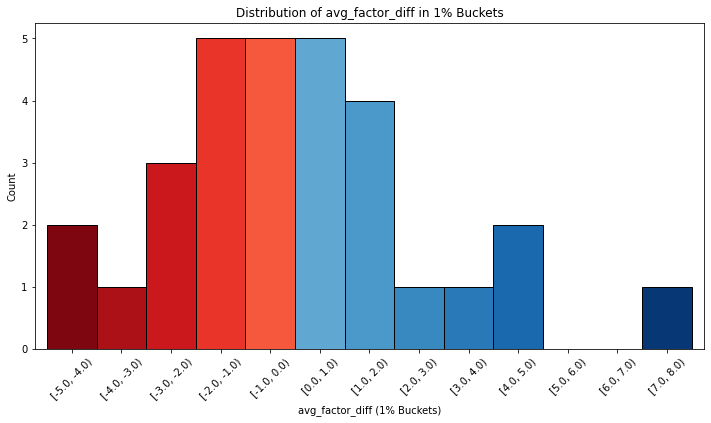

In [20]:
import seaborn as sns
from matplotlib.colors import TwoSlopeNorm

def plot_percentage_buckets(df, column):
    """
    Plots a bar chart for a given column with 1% buckets and color scaling.
    
    - Lower negative values → Darker Red
    - Higher positive values → Darker Blue
    - Near zero → Lighter shades
    """
    # Define bin edges from the min to max, rounding to the nearest whole number
    min_val = np.floor(df[column].min())  # Round down to nearest whole number
    max_val = np.ceil(df[column].max())   # Round up to nearest whole number

    # Create bins in 1% increments
    bins = np.arange(min_val, max_val + 1, 1)
    
    # Cut data into percentage buckets
    df['Buckets'] = pd.cut(df[column], bins=bins, right=False, precision=1)

    # Count occurrences in each bucket
    bucket_counts = df['Buckets'].value_counts().sort_index()

    # Normalize the bin values for color mapping
    norm = TwoSlopeNorm(vmin=min_val, vcenter=0, vmax=max_val)
    
    # Generate colors (reds for negatives, blues for positives)
    colors = [sns.color_palette("Reds_r", as_cmap=True)(norm(val)) if val < 0 
              else sns.color_palette("Blues", as_cmap=True)(norm(val)) 
              for val in bucket_counts.index.categories.mid]

    # Plot
    plt.figure(figsize=(12, 6))
    bucket_counts.plot(kind='bar', color=colors, width=1, edgecolor='black')
    
    # Labels & title
    plt.xlabel(f"{column} (1% Buckets)")
    plt.ylabel("Count")
    plt.title(f"Distribution of {column} in 1% Buckets")
    plt.xticks(rotation=45)

    # Show plot
    plt.show()

# Plot the factor differences
plot_percentage_buckets(scaling_df, 'avg_factor_diff')

A scan through the factor difference column shows no team is overly dissimilar from the average factor of ~1.716. There is one  outlier in the Houston Rockets at a 7.2% difference, but all others are below 5% with most teams concentrated withing 2% of 0. Given the lack of clarity surrounding the reasoning behind the dip in offensive rating due to the shot clock filter, this factor will operate as a resonable approximation.

### Applying Factor and Final Aggregation

In [21]:
for timeframe in final_shot_clock_dfs:
    final_shot_clock_dfs[timeframe]['SCALED_PPP'] = final_shot_clock_dfs[timeframe]['PPP'] * factor_avg
    print(final_shot_clock_dfs[timeframe].head())

      TEAM_ID             TEAM_NAME  Total_POSS  Total_PTS       PPP  \
0  1610612737         Atlanta Hawks       11197       7366  0.657855   
1  1610612738        Boston Celtics       10340       7150  0.691489   
2  1610612739   Cleveland Cavaliers       10815       7753  0.716875   
3  1610612740  New Orleans Pelicans       10892       6978  0.640654   
4  1610612741         Chicago Bulls       11010       7335  0.666213   

  SC_REMAINING  SCALED_PPP  
0        24-22    1.128840  
1        24-22    1.186555  
2        24-22    1.230115  
3        24-22    1.099324  
4        24-22    1.143182  
      TEAM_ID             TEAM_NAME  Total_POSS  Total_PTS       PPP  \
0  1610612737         Atlanta Hawks        8191       5972  0.729093   
1  1610612738        Boston Celtics        7510       6016  0.801065   
2  1610612739   Cleveland Cavaliers        7992       6471  0.809685   
3  1610612740  New Orleans Pelicans        7913       5636  0.712246   
4  1610612741         Chicago Bul